In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=8)
palette

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

In [4]:
print(palette.as_hex())

['#482878', '#3e4989', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6ece58', '#b5de2b']


# Lotka-Volterra equations

\begin{align}
\dot X_1 &= a_1 X_1 - a_2 X_1 X_2 \\
\dot X_2 &= a_3 X_1 X_2 - a_4 X_2 - a_5 X_2 X_3 \\
\dot X_3 &= a_6 X_2 X_3 - a_7 X_3 \\
\end{align}

In [3]:
def modelLV(Y, t, a1, a2, a3, a4, a5, a6, a7):
    X1, X2, X3 = Y
    
    dX1 = a1*X1 - a2*X1*X2
    dX2 = a3*X1*X2 - a4*X2 - a5*X2*X3
    dX3 = a6*X2*X3 - a7*X3
    
    return [dX1, dX2, dX3]

In [4]:
a1 = 0.14 # Reproduction rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = 0.15 # Reproduction rate of X2 in presence of X1
a4 = 0.11 # Mortality rate of X1
a5 = 0.05 # Rate of predation of X3 on X2
a6 = 0.06 # Reproduction rate of X3 in presence of X1
a7 = 0.05 # Mortality rate of X3

In [5]:
names=['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7']

In [6]:
dfGroundPars = pd.DataFrame([a1, a2, a3, a4, a5, a6, a7]).T
dfGroundPars.columns = names

In [7]:
dfGroundPars

,a1,a2,a3,a4,a5,a6,a7
0,0.14,0.16,0.15,0.11,0.05,0.06,0.05


# Generating data

In [193]:
a1 = dfGroundPars['a1'][0]
a2 = dfGroundPars['a2'][0]
a3 = dfGroundPars['a3'][0]
a4 = dfGroundPars['a4'][0]
a5 = dfGroundPars['a5'][0]
a6 = dfGroundPars['a6'][0]
a7 = dfGroundPars['a7'][0]

In [8]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

In [9]:
sol = odeint(modelLV, Y0, t, args=(a1, a2, a3, a4, a5, a6, a7))

In [10]:
X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

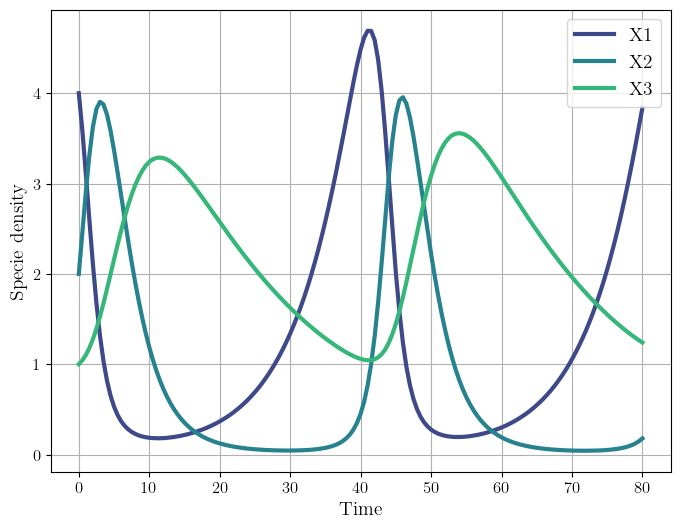

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X1_g, lw=3, color=palette[1], label='X1')
axs.plot(t, X2_g, lw=3, color=palette[3], label='X2')
axs.plot(t, X3_g, lw=3, color=palette[5], label='X3')
axs.legend(loc='best')
axs.set_xlabel('Time')
axs.set_ylabel('Specie density')
axs.grid()

plt.show()

In [49]:
dfData_clean = pd.DataFrame(np.transpose([t[0::10],X1[0::10],X2[0::10],X3[0::10]]), columns=['Time','X1','X2','X3'])

In [58]:
data = []
std = 0.25
samples = 5
for i in range(len(dfData_clean)):
    time = dfData_clean['Time'][i]
    x1 = dfData_clean['X1'][i]
    x2 = dfData_clean['X2'][i]
    x3 = dfData_clean['X3'][i]
    for j in range(samples):
        aux = [time, np.random.normal(x1, std), np.random.normal(x2, std), np.random.normal(x3, std)]
        data.append(aux)

dfData_noise = pd.DataFrame(data, columns=['Time','X1','X2','X3'])

In [59]:
# dfData_clean.to_csv('LVdata_clean.data', sep=' ', index=False, float_format='%.2f')
dfData_noise.to_csv('LVdata_noise.data', sep=' ', index=False, float_format='%.2f')

# Recovering parameters

In [12]:
dfData = pd.read_csv('LVdata_noise.data', sep=' ')

In [13]:
dfQual = pd.read_csv('LVdata_qual.data', sep=' ')

In [14]:
dfParams = pd.read_csv('../bestPars.dat', sep=' ', names=names)

In [15]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

In [16]:
for i in range(dfParams.shape[0]):
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]

    sol = odeint(modelLV, Y0, t, args=(a1, a2, a3, a4, a5, a6, a7))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

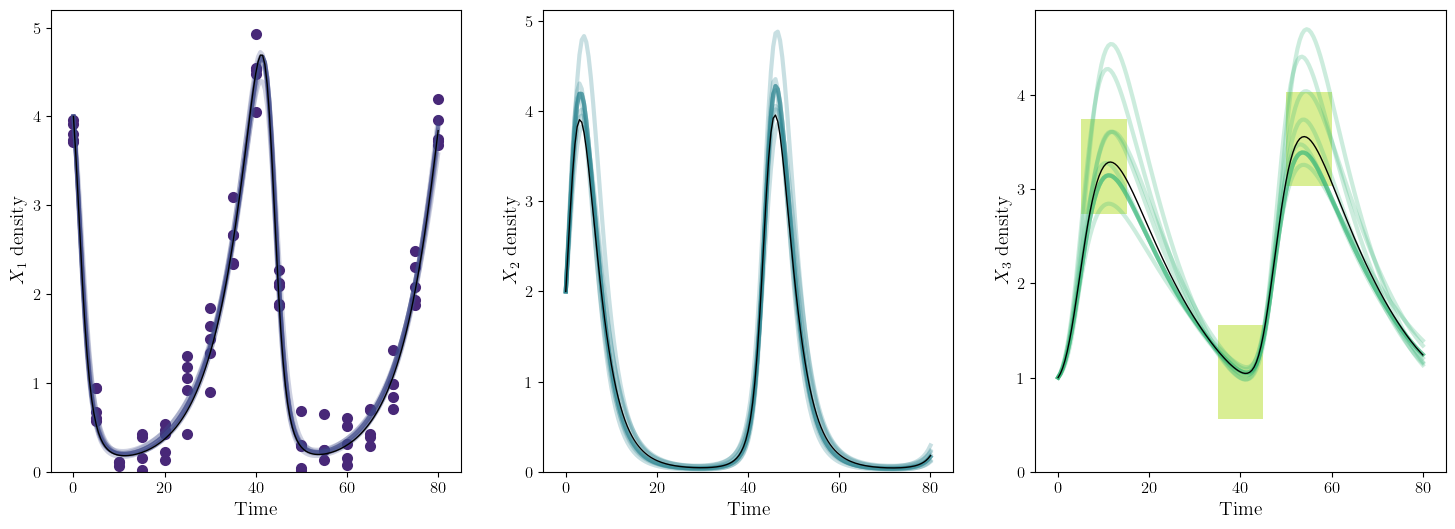

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.25)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.25)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.25)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 10
valueWindow = 1
for i in range(len(dfQual['Time'])):
    rect = plt.Rectangle((dfQual['Time'].values[i]- timeWindow/2, dfQual['Value'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [45]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [46]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

In [50]:
df2

,Parameters,Values
0,a1,0.14
1,a2,0.16
2,a3,0.15
3,a4,0.11
4,a5,0.05
5,a6,0.06
6,a7,0.05


<Axes: xlabel='Parameters', ylabel='Values'>

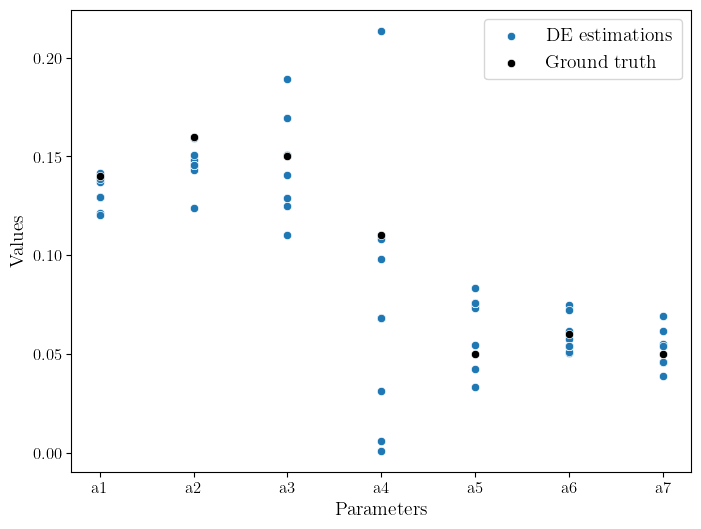

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')

## RMSE landscape

In [188]:
dfRMSEs = pd.read_csv('../pars.dat', sep=' ', skiprows=1,
                      names=['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'RMSE', 'it'])

In [189]:
dfPars = dfRMSEs.drop(columns=['RMSE', 'it'])
dfPars = pd.concat([dfPars, dfGroundPars], ignore_index=True)

In [190]:
dataMat = StandardScaler().fit_transform(dfPars.values) # Normalize
dataPC = PCA(n_components=2).fit_transform(dataMat)

In [191]:
dfPCpars = pd.DataFrame(dataPC, columns = ['PC 1', 'PC 2'])

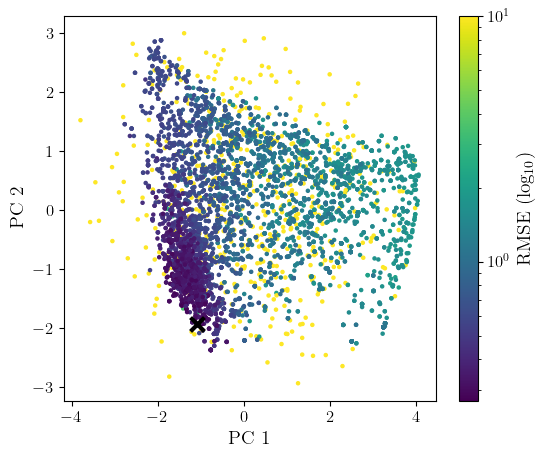

In [192]:
plt.figure(figsize=(6,5))

points = plt.scatter(dfPCpars['PC 1'][:-1], dfPCpars['PC 2'][:-1], c=dfRMSEs['RMSE'], s=5, cmap='viridis',
                     norm='log', vmax=10)
plt.scatter(dfPCpars['PC 1'][-1:].values, dfPCpars['PC 2'][-1:].values, c='k', s=100, marker="x", lw=3)

plt.colorbar(points, label='RMSE (log$_{10}$)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()